1)
Installation von Tensorflow und KEras auf Version 2.6
Installation des Image Augumentation Packetes zur Bearbeitung der Trainingsbilder

In [ ]:
!pip3 install tensorflow==2.6.*
!pip3 install keras==2.6.*
!pip3 install imgaug

     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 5.6 MB 41.4 MB/s 
     |████████████████████████████████| 462 kB 33.8 MB/s 
     |████████████████████████████████| 1.3 MB 53.1 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=2f2fa091ab0c78f23e4a149f0d654d162a0d8c2301360d510a5c56408d1ef842
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=bccf3816fd82ae5874498d9b8bc499e33465178060975e4ca9bba5096a2b170d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting

2) Importierung der benötigten Bibliotheken

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

3) Download der Trainingsdaten von Google Drive

In [ ]:
!cp -r /content/drive/MyDrive/Projekte/Self-Driving-Car/Software/model_training/Lane-Detection/data/raspicar /content

Einlesen der CSV Datei in ein Pandas Dataframe und bearbeitung des Dataframes zur weiteren benutzung.

In [ ]:
datadir = 'raspicar'
# Einteilung der Spaltenbeschriftung
columns = ['center', 'steering', 'throttle', 'reverse', 'speed']
# Einlesen der CSV Datei in Pandas Dataframe
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
#Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
pd.set_option('display.max_colwidth', -1)
data['steering'] = data['steering'].round(1)
#letzte Zeile der CSV enthält keine Daten. Wird entfernt
#data.drop(data.tail(1).index, inplace=True)
#Dataframe wird ausgegeben
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,center,steering,throttle,reverse,speed
0,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_0.jpg,0.0,372.0,0,0
1,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_1.jpg,0.0,372.0,0,0
2,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_2.jpg,0.0,372.0,0,0
3,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_3.jpg,0.0,372.0,0,0
4,/home/pi/training_data/IMG/center_2021_12_14_13_59_39_4.jpg,0.0,372.0,0,0
...,...,...,...,...,...
4359,/home/pi/training_data/IMG/center_2021_12_15_09_42_23_443.jpg,0.0,375.0,0,0
4360,/home/pi/training_data/IMG/center_2021_12_15_09_42_23_444.jpg,0.0,375.0,0,0
4361,/home/pi/training_data/IMG/center_2021_12_15_09_42_23_445.jpg,0.0,375.0,0,0
4362,/home/pi/training_data/IMG/center_2021_12_15_09_42_23_446.jpg,0.0,375.0,0,0


Funktion zum entfernen des Speicherpfades mit der ntpath Bibliothek

In [1]:
def path_leaf(path):
    head, tail = ntpath.split(str(path))
    return tail

In [2]:
data['center'] = data['center'].apply(path_leaf)
data

NameError: ignored

anwendung der Funktion auf Dataframe

Erstellung eines Histogrammes mit Numpy. Hier werden die Anzahl der Bilder mit jeweiligem Lenkwinkel in vorgefertigte Körbe verteilt. In diesem Fall 25. Einen für den Lenkwinkel 0 und 12 für die jeweiligen positiven und negativen Werte.
Anschließend wird eine maximale Anzahl an Lenkwinkel definiert und die jeweiligen Bilder aus dem Dataframe entfernt. Wenn zu viele Positionen von einem Wert vorhanden sind gibt es einen Bias zu diesem Wert und das neuronale Netz wird diesen WErt mit größerer Wahrscheinlichkeit vorhersagen. Dies würde dafür sorgen dass das Auto nur geradeausfährt und selten lenkt.

total data: 4364
removed: 866
remaining: 3498
center      center_2021_12_14_13_59_39_3.jpg
steering    0                               
throttle    372                             
reverse     0                               
speed       0                               
Name: 3, dtype: object


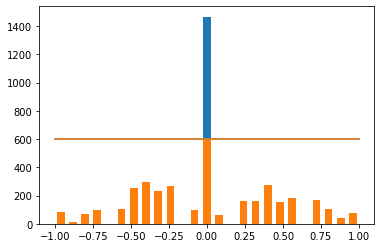

In [ ]:
num_bins = 25
samples_per_bin = 600
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print(data.iloc[1])

Funktion zum Einlesen der Lenkwinkel und dazu gehörenden Bildern. Jede Zeile wird eingelesen und der Pfad und der jeweilige Lenkwinkel extrahiert.

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    image = indexed_data[0]
    image_path.append(os.path.join(datadir, image.strip()))
    steering.append(float(indexed_data[1]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

Funktion wird angewendet. Trainings und Evaluierungsverteilung wird dargestellt. Bei verschiedener Verteilung der Lenkwinkel ist es angebracht die Trainingsstrecke in die Gegenrichtung abzufahren damit die Werte gleichmäßig Verteilt sind.

Training Samples: 2798
Valid Samples: 700


Text(0.5, 1.0, 'Validation set')

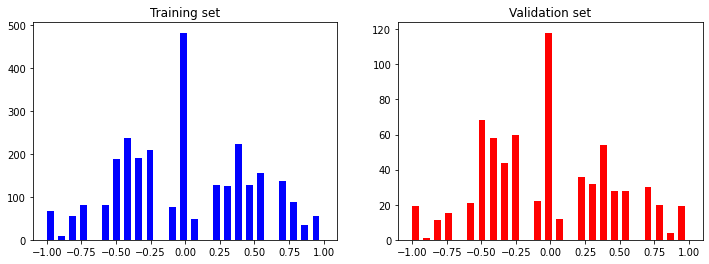

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Zoom Funktion

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [ ]:
def img_preprocess(img):
    img = img[100:,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
  
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

Aufruf des Model und anschließendes Training mit dem konfiguiertem Batch Generator

In [ ]:
model = nvidia_model()
print(model.summary())
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=14,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

UnknownError: ignored

Evaluierung und Speicherung des trainierten Modelles

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')

Validation error gut, kann mehr epochen laufen

In [ ]:
from google.colab import files
files.download('model.h5')